## 3.5 图像分类数据集(Fashion-MNIST)

在介绍softmax回归的实现前我们先引入一个多类图像分类数据集。它将在后面的章节中被多次使用，以方便我们观察比较算法之间在模型精度和计算效率上的区别。图像分类数据集中最常用的是手写数字识别数据集MNIST。但大部分模型在MNIST上的分类精度都超过了95%。为了更直观地观察**算法之间的差异**，我们将使用一个图像内容更加复杂的Fashion-MNIST数据集。

#### 笔记-机器学习中算法与模型的区别
- 机器学习中的“算法”是在数据上运行以构建机器学习“模型”的过程。
- 机器学习中的“模型”是运行在数据上的机器学习算法的输出，表示机器学习算法所学到的内容。

### 3.5.1 获取数据集

首先导入本节需要的包或模块。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet.gluon import data as gdata
import sys
import time

下面，我们通过Gluon的data包来下载这个数据集。第一次调用时会自动从网上获取数据。我们通过参数train来指定获取训练数据集或测试数据集(testing data set)。测试数据集也叫测试集(testing set)，只用来评价模型的表现，并不用来训练模型。

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

训练集中和测试集中的每个类别的图像数分别为6000和1000。因为有10个类别，所以训练集和测试集的样本数分别为60000和10000。

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

我们可以通过方括号[]来访问任意一个样本，下面获取第一个样本的图像和标签。

In [4]:
feature, label = mnist_train[0]

变量feature对应高和宽均为28像素的图像。每个像素的数值为0到255之间8位无符号整数(uint8)。它使用三维的NDArray存储。其中的最后一维是通道数。因为数据集中是灰度图像，所以通道数为1。为了表述简洁，我们将高和宽分别为$h$和$w$像素的图像的形状记为$h \times w$或($h$,$w$)。

In [5]:
feature, feature.shape, feature.dtype

(
 [[[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]
 
  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]
 
  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]
 
  [[  0]
   [  0]
   [  0]
   [  0]
   [  4]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [ 62]
   [ 61]
   [ 21]
   [ 29]
   [ 23]
   [ 51]
   [136]
   [ 61]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]

图像的标签使用NumPy的标量表示。它的类型为32位整数(int32)。

In [6]:
label, type(label), label.dtype

(2, numpy.int32, dtype('int32'))

Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [7]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels] # 列表解析

下面定义一个可以在一行里面画出多张图像和对应标签的函数。

In [8]:
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = d2l.plt.subplots(1, len(images), figsize=(14, 14))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

现在，我们看一下训练数据集中前9个样本的图像内容和文本标签。


[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0

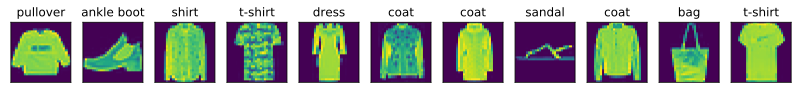

In [9]:
X, y = mnist_train[0:11]
show_fashion_mnist(X, get_fashion_mnist_labels(y))
print(X)
print(y)

### 3.5.2 读取小批量

我们将在训练数据集上训练模型，并将训练好的模型在测试数据集上评价模型的表现。虽然我们可以像[“线性回归的从零开始实现”](linear-regression-scratch.ipynb)一节中那样通过yield来定义读取小批量数据样本的函数，但为了代码简洁，这里我们直接创建DataLoader实例。该实例每次读取一个样本数为batch_size的小批量数据。这里的批量大小batch_size是一个超参数。

在实践中，数据读取经常是训练的性能瓶颈，特别当模型较简单或者计算硬件性能较高时。Gluon的DataLoader中一个很方便的功能是允许使用多进程来加速数据读取(暂不支持Windows操作系统)。这里我们通过参数num_workers来设置4个进程读取数据。

此外，我们通过ToTensor实例将图像数据从uint8格式变换成32位浮点数格式，并除以255使得所有像素的数值均在0到1之间。ToTensor实例还将图像通道从最后一维移到最前一维来方便之后介绍的卷积神经网络计算。通过数据集的transform_first函数，我们将ToTensor的变换应用在每个数据样本(图像和标签)的第一个元素，即图像之上。

In [10]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()

if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速数据读取
else:
    num_workers = 4
    
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                             batch_size, shuffle=True,
                             num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(train_iter),
                            batch_size, shuffle=False,
                            num_workers=num_workers)

我们将获取并读取Fashion-MNIST数据集的逻辑封装在d2lzh.load_data_fashion_mnist函数中供后面章节调用。该函数将返回train_iter和test_iter两个变量。随着本书内容的不断深入，我们会进一步改进该函数。它的完整实现将在[“深度卷积神经网络（AlexNet）”](../chapter_convolutional-neural-networks/alexnet.ipynb)一节中描述。

最后我们查看读取一遍训练数据需要的时间。

In [14]:
start = time.time()
i = 0

for X, y in train_iter:
    i += 1
    print('iteration ' + str(i))
    print(X, y)
'%.2f sec' % (time.time() - start)

iteration 1

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]


iteration 12

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 

<NDArray 256x1x28x28 @cpu(0)> 
[6 9 4 5 2 7 5 9 2 8 6 3 9 2 5 5 4 4 3 3 6 9 1 0 5 5 9 6 9 8 9 4 2 3 2 5 4
 5 4 6 3 8 6 9 7 6 7 9 6 5 3 2 0 3 5 4 4 0 6 0 1 5 2 1 2 3 6 9 6 7 9 8 1 9
 4 1 5 8 8 5 4 9 6 0 5 8 9 9 2 3 7 5 9 7 5 7 8 6 3 4 0 4 6 7 9 7 1 8 6 9 2
 7 5 9 9 6 8 7 9 0 3 1 1 9 5 9 9 3 7 2 9 6 7 4 7 7 4 9 2 9 3 5 5 0 8 0 7 1
 2 9 9 2 9 2 6 2 6 7 7 6 6 0 4 4 9 8 4 0 6 7 9 3 8 1 8 6 7 9 1 4 4 8 2 3 8
 0 8 2 9 9 3 6 8 4 1 8 9 1 6 7 5 2 0 6 6 3 5 3 9 1 9 5 2 0 7 7 1 0 8 9 8 4
 7 6 0 9 0 5 2 4 6 3 8 1 8 2 7 8 1 1 7 4 0 8 2 1 6 5 4 3 7 1 1 1 2 5]
<NDArray 256 @cpu(0)>
iteration 23

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.        

iteration 33

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 

iteration 44

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.2        0.
    0.        ]
   [0.         0.         0.         ... 0.3019608  0.
    0.        ]
   [0.         0.         0.         ... 0.23921569 0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 

iteration 54

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.00784314 ... 0.00784314 0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.6392157  0.
    0.        ]
   [0.         0.         0.         ... 0.77254903 0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 

iteration 65

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.12941177 0.17254902
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.     

iteration 75

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]

iteration 86

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.00392157 0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 

iteration 97

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 

iteration 107

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.00392157 0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ...

iteration 118

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.

iteration 129

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ...

<NDArray 256x1x28x28 @cpu(0)> 
[1 2 5 5 7 8 5 6 2 4 3 3 3 8 7 0 1 1 2 9 6 2 7 9 9 6 8 6 7 1 4 0 0 0 9 3 3
 1 3 0 4 1 4 0 2 9 8 5 9 9 4 5 7 0 8 9 1 8 0 5 4 0 9 9 2 5 4 9 6 1 6 6 0 0
 6 8 0 5 9 3 4 4 0 7 3 9 5 5 2 5 4 7 4 5 3 3 5 5 0 0 0 7 4 6 6 4 7 9 3 9 0
 3 1 0 0 0 0 8 4 9 2 0 9 5 5 0 5 7 7 2 4 3 9 2 4 8 4 4 4 9 2 0 0 7 4 2 8 7
 0 1 2 7 5 5 2 6 7 9 1 2 7 2 8 6 2 1 8 6 9 1 6 9 2 8 3 1 0 8 9 2 4 5 3 4 8
 7 3 8 5 3 5 1 9 2 4 3 8 7 8 7 4 8 7 4 0 6 3 4 7 1 0 2 4 6 9 3 2 5 5 5 4 8
 9 3 1 2 6 1 6 1 3 1 4 2 0 4 4 5 4 5 3 4 4 2 0 5 1 6 2 8 4 4 1 0 1 7]
<NDArray 256 @cpu(0)>
iteration 140

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0.

iteration 150

[[[[0.         0.         0.00784314 ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ...

iteration 160

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.

<NDArray 256x1x28x28 @cpu(0)> 
[9 7 5 7 1 5 8 9 3 6 6 3 7 8 5 6 7 6 0 1 9 0 6 2 4 9 5 8 8 6 0 1 2 4 8 6 7
 2 9 8 3 0 4 6 7 4 1 7 9 3 3 1 9 0 3 0 6 7 1 4 2 0 7 2 8 3 1 6 5 1 7 7 5 6
 1 3 5 5 7 5 3 8 2 2 1 4 7 3 7 0 8 4 0 3 8 0 8 9 5 1 6 7 7 1 2 3 2 8 2 2 4
 9 8 5 5 3 7 8 0 5 4 1 9 3 4 8 9 2 1 9 8 2 4 9 5 8 4 9 5 5 6 9 0 2 0 9 5 8
 8 8 8 4 2 9 7 8 9 0 4 6 9 4 0 6 5 8 9 4 4 0 7 0 4 3 5 0 1 4 7 1 9 4 7 5 6
 4 4 4 5 0 2 6 0 5 7 9 5 1 2 1 2 2 5 2 3 5 3 3 0 1 8 1 9 1 6 1 8 6 9 5 1 9
 5 9 0 1 7 0 1 3 0 7 7 7 3 3 2 2 2 5 8 7 9 1 5 9 5 1 1 6 6 6 4 3 9 0]
<NDArray 256 @cpu(0)>
iteration 171

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.       

iteration 181

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.00392157 0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ...

<NDArray 256 @cpu(0)>
iteration 192

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   

iteration 202

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ...

iteration 213

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.

<NDArray 256 @cpu(0)>
iteration 224

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   

iteration 234

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.47058824 ... 0.73333335 0.00392157
    0.        ]
   [0.         0.         0.         ... 0.92941177 0.05098039
    0.        ]
   [0.         0.         0.         ... 0.16078432 0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.       

'4.15 sec'

## 小结

* Fashion-MNIST是一个10类服饰分类数据集，之后章节里将使用它来检验不同算法的表现。
* 我们将高和宽分别为$h$和$w$像素的图像的形状记为$h \times w$或（$h$，$w$）。

## 练习

* 减小`batch_size`（如到1）会影响读取性能吗？

In [15]:
batch_size = 256

transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速数据读取
else:
    num_workers = 4
    
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                             batch_size, shuffle=True,
                             num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(train_iter),
                            batch_size, shuffle=False,
                            num_workers=num_workers)

start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'2.61 sec'

In [16]:
batch_size = 1

transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速数据读取
else:
    num_workers = 4
    
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                             batch_size, shuffle=True,
                             num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(train_iter),
                            batch_size, shuffle=False,
                            num_workers=num_workers)

start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'7.40 sec'

- 会影响，数据读取的效率会降低。

* 非Windows用户请尝试修改`num_workers`来查看它对读取性能的影响。

我的是win10系统，所以暂不尝试。

- 查阅MXNet文档，`mxnet.gluon.data.vision`里还提供了哪些别的数据集？

有MNIST、FashionMNIST、CIFAR10、CIFAR100、ImageRecordDataset和ImageFolderDataset。

- 查阅MXNet文档，`mxnet.gluon.data.vision.transforms`还提供了哪些别的变换方法？

有transforms.Compose、transforms.Cast、transforms.ToTensor、transforms.Normalize、transforms.RandomResizedCrop、transforms.CenterCrop、transforms.Resize、transforms.RandomFlipLeftRight、transforms.RandomFlipTopBottom、transforms.RandomBrightness、transforms.RandomContrast、transforms.RandomSaturation、transforms.RandomHue、transforms.RandomColorJitter和transforms.RandomLighting。